In [3]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf
from IPython import display
from matplotlib import pyplot as plt
from typing import Optional
import os
np.int = int

# Ensure TensorFlow runs on CPU only (if required)
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [4]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

In [5]:
data_dir = pathlib.Path('/home/fariborz/courses/Research/data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

In [6]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1282


In [7]:
sample_file = filenames[1]
print(sample_file)

/home/fariborz/courses/Research/data/maestro-v2.0.0/2018/MIDI-Unprocessed_Chamber5_MID--AUDIO_18_R3_2018_wav--1.midi


In [8]:
pm = pretty_midi.PrettyMIDI(sample_file)
print(pm)

In [9]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [10]:
display_audio(pm)

In [11]:
print('Number of Instrument: ', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print(instrument_name)

Number of Instrument:  1
Acoustic Grand Piano


In [12]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=79, note_name=G5, duration=0.1602
1: pitch=78, note_name=F#5, duration=0.1458
2: pitch=74, note_name=D5, duration=0.0768
3: pitch=71, note_name=B4, duration=0.1810
4: pitch=62, note_name=D4, duration=0.2070
5: pitch=59, note_name=B3, duration=0.2083
6: pitch=66, note_name=F#4, duration=0.7461
7: pitch=47, note_name=B2, duration=0.4701
8: pitch=59, note_name=B3, duration=0.1602
9: pitch=64, note_name=E4, duration=0.2031


In [13]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
    pm = pretty_midi.PrettyMIDI(midi_file)
    instrument = pm.instruments[0]
    notes = collections.defaultdict(list)
    
    # Sort the notes by start time
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start
    
    for note in sorted_notes:
        start = note.start
        end = note.end
        notes['pitch'].append(note.pitch)
        notes['start'].append(start)
        notes['end'].append(end)
        notes['step'].append(start - prev_start)
        notes['duration'].append(end - start)
        prev_start = start
    
    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [14]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

pitch     start       end      step  duration
0     79  0.983073  1.143229  0.000000  0.160156
1     78  1.088542  1.234375  0.105469  0.145833
2     74  1.197917  1.274740  0.109375  0.076823
3     71  1.292969  1.473958  0.095052  0.180990
4     66  1.438802  2.184896  0.145833  0.746094

In [15]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['G5', 'F#5', 'D5', 'B4', 'F#4', 'D4', 'B3', 'B2', 'B4', 'G3'],
      dtype='<U3')

In [16]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

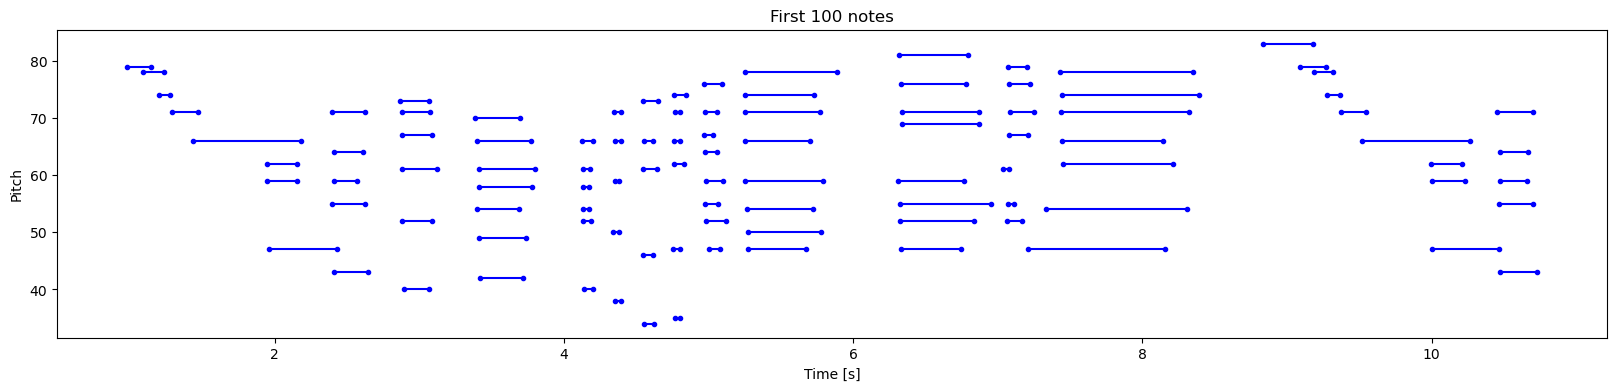

In [17]:
plot_piano_roll(raw_notes, count=100)

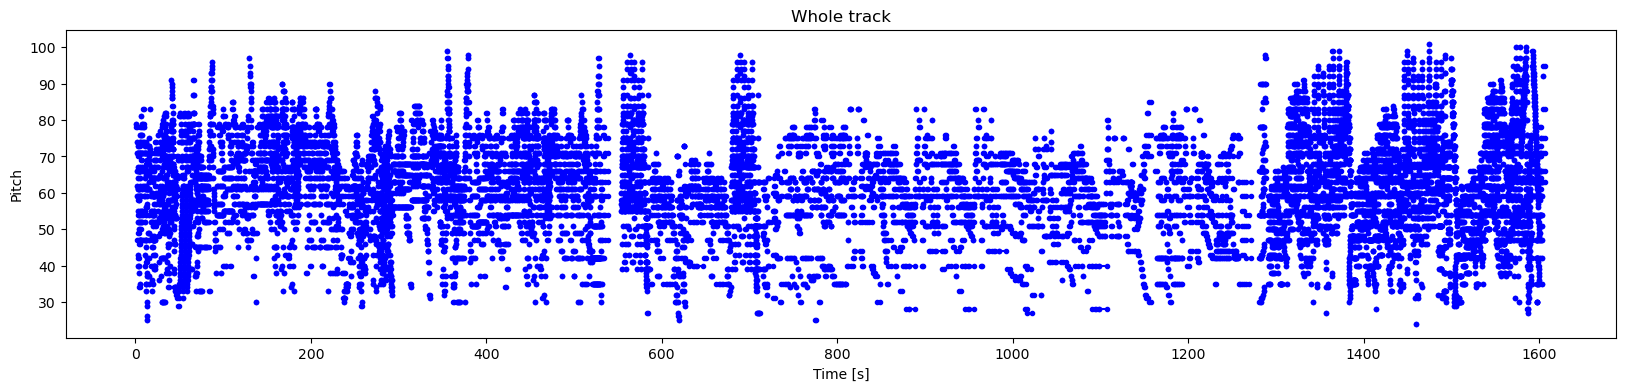

In [18]:
plot_piano_roll(raw_notes)

In [19]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

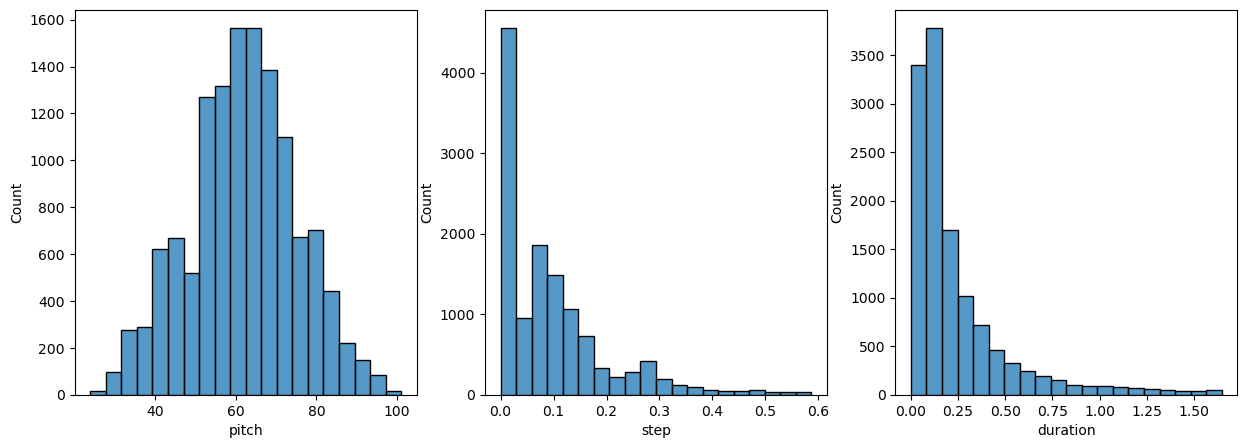

In [20]:
plot_distributions(raw_notes)

In [21]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [22]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

In [23]:
display_audio(example_pm)

In [24]:
num_files = 5
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [25]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 51594


In [26]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [27]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [28]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [29]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [30]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[5.39062500e-01 0.00000000e+00 1.99869792e+00]
 [4.45312500e-01 1.04166667e-02 1.98046875e+00]
 [3.82812500e-01 1.30208333e-03 3.12500000e-02]
 [4.76562500e-01 0.00000000e+00 1.98307292e+00]
 [3.51562500e-01 1.30208333e-03 2.99479167e-02]
 [2.57812500e-01 7.25260417e-01 5.33854167e-01]
 [3.82812500e-01 1.22916667e+00 3.64583333e-02]
 [3.51562500e-01 2.60416667e-03 3.25520833e-02]
 [5.39062500e-01 2.69531250e-01 1.74609375e+00]
 [4.84375000e-01 9.11458333e-03 1.71614583e+00]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=57.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.005208333333333037>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.02734375>}


2024-12-11 17:50:50.143227: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [31]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [32]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

In [33]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [34]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 25, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 128)       │     67,584 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ duration (Dense)    │ (None, 1)         │        129 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pitch (Dense)       │ (None, 128)       │     16,512 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ step (Dense)        │ (None, 1)         │        129 │ lstm[0][0]        │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,354 (329.51 KB)

 Trainable params: 84,354 (329.51 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
losses = model.evaluate(train_ds, return_dict=True)
losses

805/805 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - duration_loss: 0.3388 - loss: 5.5277 - pitch_loss: 4.8486 - step_loss: 0.3403


2024-12-11 17:51:07.472245: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/fariborz/anaconda3/envs/MGU/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


{'duration_loss': 0.34861892461776733,
 'loss': 5.5379767417907715,
 'pitch_loss': 4.84260892868042,
 'step_loss': 0.3467530310153961}

In [36]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [37]:
model.evaluate(train_ds, return_dict=True)

805/805 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - duration_loss: 0.3388 - loss: 0.9215 - pitch_loss: 0.2424 - step_loss: 0.3403


{'duration_loss': 0.34861892461776733,
 'loss': 0.9375020265579224,
 'pitch_loss': 0.24213021993637085,
 'step_loss': 0.3467530310153961}

In [38]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}.weights.h5',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [39]:
%%time
epochs = 10

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/10
805/805 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - duration_loss: 0.1260 - loss: 0.4255 - pitch_loss: 0.2088 - step_loss: 0.0907
Epoch 2/10
 11/805 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - duration_loss: 0.1037 - loss: 0.3539 - pitch_loss: 0.2002 - step_loss: 0.0499

2024-12-11 17:51:27.407301: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


805/805 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - duration_loss: 0.1163 - loss: 0.3943 - pitch_loss: 0.1970 - step_loss: 0.0810
Epoch 3/10
805/805 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - duration_loss: 0.1144 - loss: 0.3869 - pitch_loss: 0.1930 - step_loss: 0.0795
Epoch 4/10
805/805 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - duration_loss: 0.1132 - loss: 0.3824 - pitch_loss: 0.1920 - step_loss: 0.0773
Epoch 5/10
805/805 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - duration_loss: 0.1121 - loss: 0.3813 - pitch_loss: 0.1914 - step_loss: 0.0778
Epoch 6/10
 11/805 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - duration_loss: 0.0967 - loss: 0.3392 - pitch_loss: 0.1943 - step_loss: 0.0481

2024-12-11 17:51:59.645229: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


805/805 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - duration_loss: 0.1106 - loss: 0.3786 - pitch_loss: 0.1913 - step_loss: 0.0766
Epoch 7/10
805/805 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - duration_loss: 0.1085 - loss: 0.3742 - pitch_loss: 0.1909 - step_loss: 0.0747
Epoch 8/10
805/805 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - duration_loss: 0.1072 - loss: 0.3702 - pitch_loss: 0.1910 - step_loss: 0.0720
Epoch 9/10
805/805 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - duration_loss: 0.1066 - loss: 0.3727 - pitch_loss: 0.1912 - step_loss: 0.0749
Epoch 10/10
805/805 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - duration_loss: 0.1039 - loss: 0.3654 - pitch_loss: 0.1903 - step_loss: 0.0711
Restoring model weights from the end of the best epoch: 10.
CPU times: user 3min 3s, sys: 10.5 s, total: 3min 13s
Wall time: 1min 26s


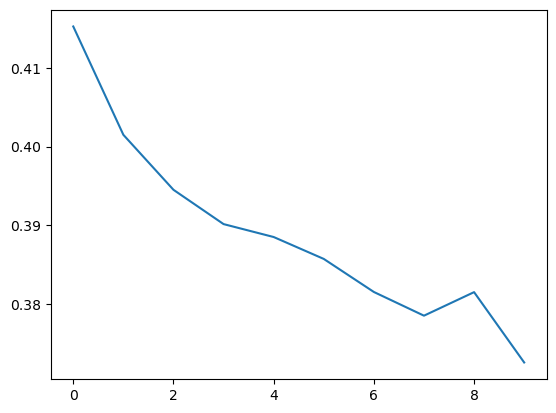

In [40]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [41]:
def predict_next_note(
    notes: np.ndarray, 
    model: tf.keras.Model, 
    temperature: float = 1.0) -> tuple[int, float, float]:
  """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [42]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━

In [43]:
generated_notes.head(10)

pitch      step  duration     start       end
0     64  0.284943  0.283102  0.284943  0.568045
1     96  0.245903  0.793460  0.530846  1.324306
2     96  0.267492  0.836850  0.798338  1.635189
3     85  0.270771  0.843306  1.069109  1.912415
4     91  0.271333  0.844105  1.340443  2.184548
5     87  0.271153  0.844600  1.611596  2.456195
6     75  0.272149  0.843527  1.883745  2.727272
7     90  0.272432  0.843791  2.156177  2.999967
8     45  0.271826  0.845724  2.428002  3.273726
9     90  0.278178  0.831438  2.706180  3.537618

In [44]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

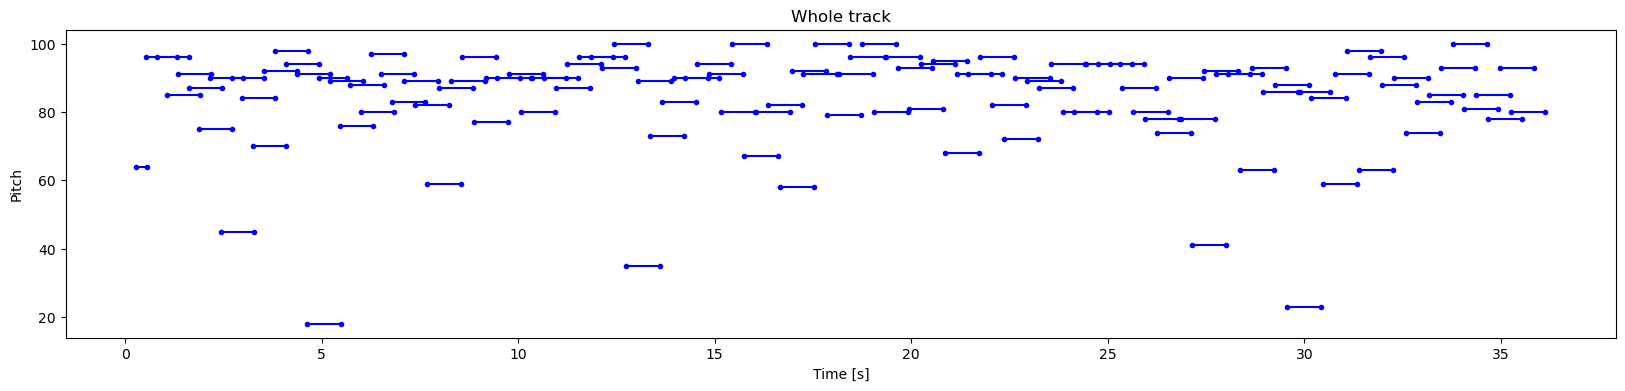

In [45]:
plot_piano_roll(generated_notes)

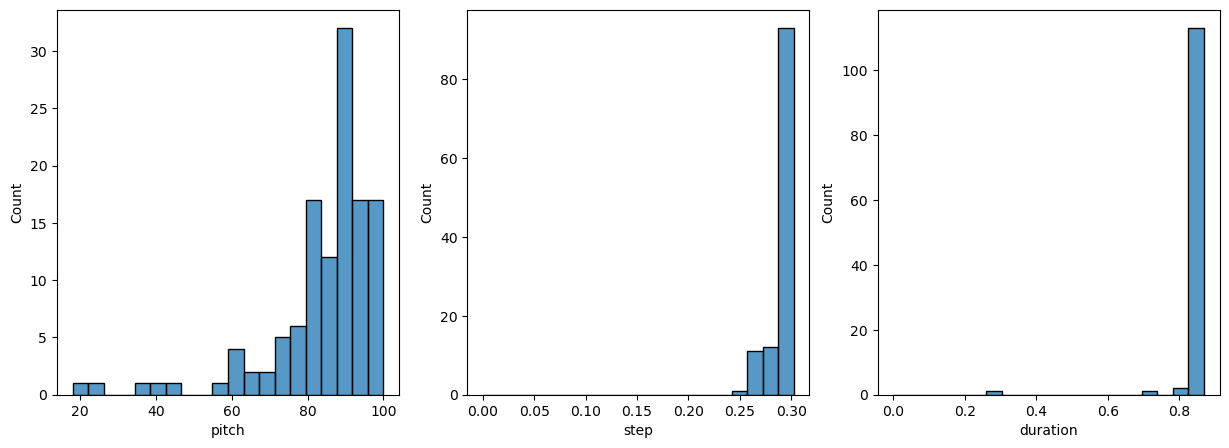

In [46]:
plot_distributions(generated_notes)